In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
df=pd.read_csv('titanic_train.csv')
df.set_index('PassengerId' , inplace=True)

In [38]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
df.shape

(891, 11)

## Exploratory Data Analysis

We will drop few columns that are not useful eg. Name , It does not affect our target column

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [41]:
df.drop('Name' , axis='columns' , inplace=True)

<Axes: ylabel='PassengerId'>

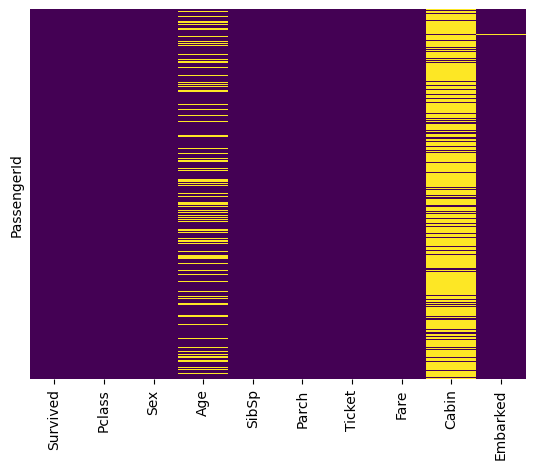

In [42]:
sns.heatmap(df.isnull() , cbar=False , cmap='viridis' , yticklabels=False)

Since Embarked has only 2 missing values we will fill it with the most frequent value.

Since Cabin has alot of missing values(around 77%) , imputing them seems to be a bad idea so , we will drop that column

In [43]:
df.Embarked.fillna(df.Embarked.mode()[0] , inplace=True)
df.drop('Cabin' ,axis='columns' , inplace=True)

In [44]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


<Axes: >

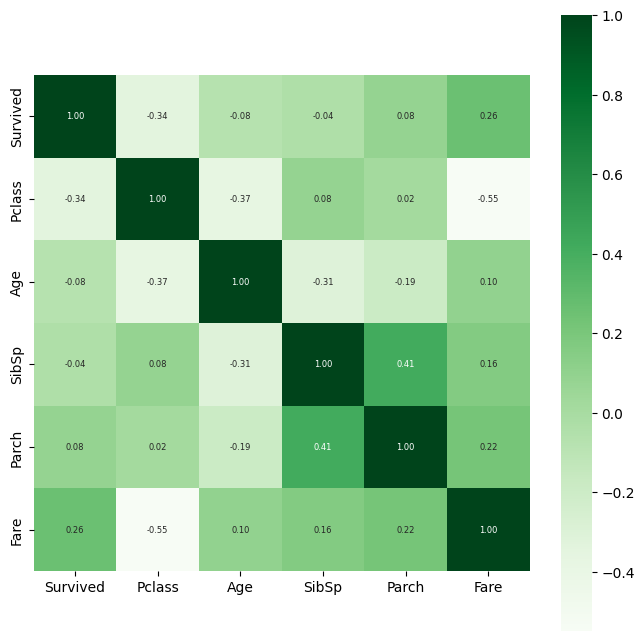

In [45]:
plt.figure(figsize=(8,8))
sns.heatmap(numeric_df.corr() , annot=True , cmap='Greens'  , square=True , fmt='.2f' ,cbar=True ,
            annot_kws={'size':6})

From the heatmap its quite clear that  Age and Pclass are correlated (negatively)
So we can use Pclass column to derive missing values in Age column



<Axes: xlabel='Pclass', ylabel='Age'>

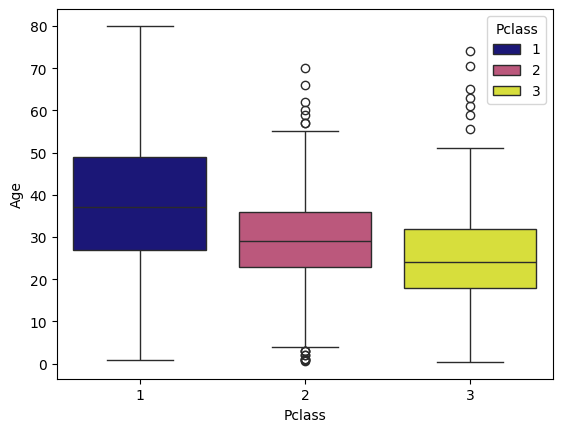

In [46]:
sns.boxplot(x=df.Pclass , y=df.Age , hue=df.Pclass , palette='plasma')

In [47]:
def imputeAge(col):
  Pclass=col[0]
  if(Pclass==1):
    return 37
  elif(Pclass==2):
    return 28
  else:
    return 24

df['Age']=df[['Pclass' , 'Age']].apply(imputeAge , axis=1)

In [48]:
for col in df.columns:
  if(df[col].dtype==object):
    print(col , ':' , df[col].nunique())

# We will labelEncode Sex column , one hot encode Embarked and since
# there  are many unique values in Ticket around 75% we will drop it for now

Sex : 2
Ticket : 681
Embarked : 3


In [49]:
df.drop('Ticket', axis='columns' , inplace=True)

In [50]:
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
df['Sex']=le.fit_transform(df['Sex'])
df=pd.get_dummies(df , columns=['Embarked'])

df['Embarked_C']=df['Embarked_C'].astype(int)
df['Embarked_S']=df['Embarked_S'].astype(int)
df['Embarked_Q']=df['Embarked_Q'].astype(int)

In [51]:
df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,1,24,1,0,7.2500,0,0,1
2,1,1,0,37,1,0,71.2833,1,0,0
3,1,3,0,24,0,0,7.9250,0,0,1
4,1,1,0,37,1,0,53.1000,0,0,1
5,0,3,1,24,0,0,8.0500,0,0,1


In [52]:
df.shape

(891, 10)

## Splitting Data

In [53]:
X=df.drop('Survived' , axis='columns')
y=df['Survived']

In [54]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test=train_test_split(X , y , test_size=0.2 , random_state=0)

## Decision Trees

In [55]:
accuracy_dict={}
f1_scores={}
roc_auc_scores={}

We will create a function evaluate model that returns accuracy, f1 score , roc auc score and plots the confusion matrix. This will help us to analyze model performance based on different evaluation metrics

In [56]:
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , f1_score ,roc_auc_score
def evaluate_model(model):
  y_pred=model.predict(X_test)
  y_prob=model.predict_proba(X_test)[: , 1]
  y_pred_train=model.predict(X_train)
  clf_report = pd.DataFrame(classification_report(y_test , y_pred ,output_dict=True ))
  print(f"Accuracy Score Test: {accuracy_score(y_test, y_pred) * 100:.2f}%")
  print("_______________________________________________")
  print(f"Accuracy Score Train: {accuracy_score(y_train, y_pred_train) * 100:.2f}%")
  print("_______________________________________________")
  print(f"CLASSIFICATION REPORT:\n{clf_report}")
  print("_______________________________________________")
  cm=confusion_matrix(y_test, y_pred)
  sns.heatmap(cm ,annot=True , cbar=False , yticklabels=False)
  acc=accuracy_score(y_test, y_pred) * 100
  f1=f1_score(y_test , y_pred)*100
  roc_auc=roc_auc_score(y_test , y_prob)*100
  return acc , f1 , roc_auc



In [57]:
from sklearn.tree import DecisionTreeClassifier
tree_clf=DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train , y_train)


DecisionTreeClassifier(random_state=0)

Accuracy Score Test: 83.80%
_______________________________________________
Accuracy Score Train: 92.42%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.852174   0.812500  0.837989    0.832337      0.836881
recall       0.890909   0.753623  0.837989    0.822266      0.837989
f1-score     0.871111   0.781955  0.837989    0.826533      0.836744
support    110.000000  69.000000  0.837989  179.000000    179.000000
_______________________________________________


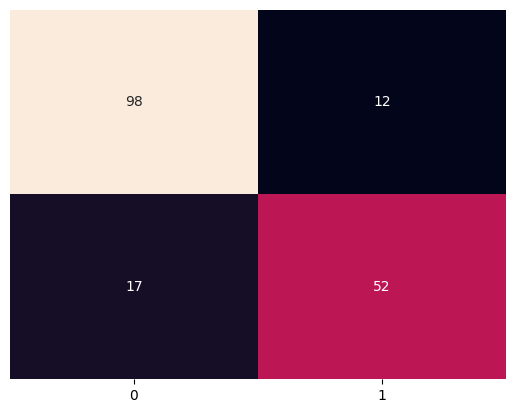

In [58]:
acc , f1 , roc_auc=evaluate_model(tree_clf)
accuracy_dict['Tree']=acc
f1_scores['Tree']=f1
roc_auc_scores['Tree']=roc_auc

## Decision Tree Hyperparameter Tuning

Features like max_depth (default:None) , min_samples_split (default:2) , min_samples_leaf(default:1) , increasing all of these parameters will help us to reduce overfitting (seeing previous scores of our model , there's a significant difference in train and test accuracies)


We will also explore some other parameters to improve accuracy

We will use GridSearchCV to find the best hyperparameters for us , It will try out all possible combinations of values that we give to it

In [59]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV

params={
    "criterion":['gini' , 'entropy'],
    "splitter":['best', 'random'],
    "max_depth":list(range(1,20)),
    "min_samples_split":[2,3,4],
    "min_samples_leaf":list(range(1,20)),
}

tree_clf=DecisionTreeClassifier(random_state=0)
tree_cv=GridSearchCV(
    tree_clf ,
    params ,
    scoring='f1',
    cv=5,
    verbose=1
)

tree_cv.fit(X_train , y_train)
best_parameters=tree_cv.best_params_
print(f"Best paramters: {best_parameters})")


Fitting 5 folds for each of 4332 candidates, totalling 21660 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'best'})


In [93]:
result=pd.DataFrame(tree_cv.cv_results_)

In [94]:
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003512,0.000979,0.003012,0.000135,gini,1,1,2,best,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.660377,0.759259,0.673267,0.693069,0.75,0.707195,0.040213,212
1,0.003162,0.000541,0.003284,0.000848,gini,1,1,2,random,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.660377,0.759259,0.673267,0.693069,0.75,0.707195,0.040213,212
2,0.002909,0.000107,0.003279,0.000919,gini,1,1,3,best,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.660377,0.759259,0.673267,0.693069,0.75,0.707195,0.040213,212
3,0.003239,0.000708,0.003005,0.000257,gini,1,1,3,random,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.660377,0.759259,0.673267,0.693069,0.75,0.707195,0.040213,212
4,0.003761,0.001270,0.004053,0.001298,gini,1,1,4,best,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.660377,0.759259,0.673267,0.693069,0.75,0.707195,0.040213,212


The result dataframe shows us various things about different combinations of hyperparameters , mean_test_score gives us the mean of cross validation scores, which further decides the best parameters

Accuracy Score Test: 84.92%
_______________________________________________
Accuracy Score Train: 84.27%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision    0.86087   0.828125  0.849162    0.844497      0.848247
recall       0.90000   0.768116  0.849162    0.834058      0.849162
f1-score     0.88000   0.796992  0.849162    0.838496      0.848003
support    110.00000  69.000000  0.849162  179.000000    179.000000
_______________________________________________


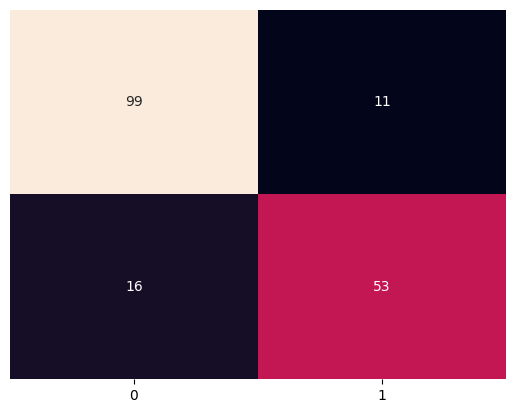

In [60]:
tree_clf_tuned=DecisionTreeClassifier(**best_parameters)
tree_clf_tuned.fit(X_train , y_train)
acc , f1 , roc_auc=evaluate_model(tree_clf_tuned)
accuracy_dict['Tree_tuned']=acc
f1_scores['Tree_tuned']=f1
roc_auc_scores['Tree_tuned']=roc_auc

After feeding best parameters in our model , accuracy of our model increased  ,moreover test and train accuracies are quite close indicating that we have successfully tackled overfitting issue

## RandomForestClassifier

Accuracy Score Test: 82.12%
_______________________________________________
Accuracy Score Train: 92.42%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.854545   0.768116  0.821229    0.811331      0.821229
recall       0.854545   0.768116  0.821229    0.811331      0.821229
f1-score     0.854545   0.768116  0.821229    0.811331      0.821229
support    110.000000  69.000000  0.821229  179.000000    179.000000
_______________________________________________


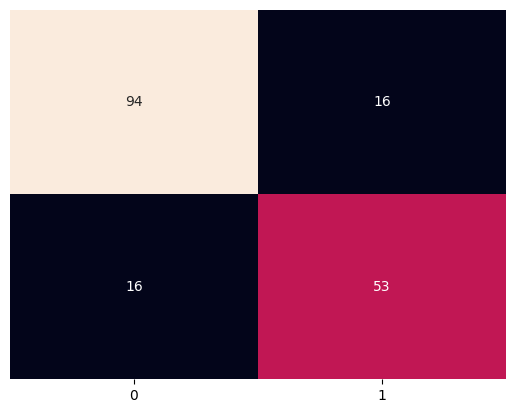

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(n_estimators=100 ,random_state=0)
rf_clf.fit(X_train,y_train)
acc , f1 , roc_auc=evaluate_model(rf_clf)
accuracy_dict['RandomForest']=acc
f1_scores['RandomForest']=f1
roc_auc_scores['RandomForest']=roc_auc


* There's a huge difference in test and train accuracies indicating our model is not able to generalize well , or overfits.

* So will use some hyperparameters like max_depth,min_samples_split and min_samples_leaf to deal with that.
* Moreover hyperparameters like max_features and bootstrap will introduce some randomness and will help the model to generalize well.
* Increasing no. of trees will help us to improve model's performance


### RandomForest Hyperparameter tuning

In [62]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params_grid = {
    'n_estimators': [100, 500, 1000],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [2, 5 , None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 10],
    'bootstrap': [True, False]
}

rf_clf=RandomForestClassifier(random_state=0)
rf_cv=RandomizedSearchCV(
    rf_clf ,
    params_grid ,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=1,
)

rf_cv.fit(X_train , y_train)
best_params_rf=rf_cv.best_params_
print(f"Best parameters: {best_params_rf}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}


Accuracy Score Test: 83.80%
_______________________________________________
Accuracy Score Train: 83.43%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.813953   0.900000  0.837989    0.856977      0.847122
recall       0.954545   0.652174  0.837989    0.803360      0.837989
f1-score     0.878661   0.756303  0.837989    0.817482      0.831495
support    110.000000  69.000000  0.837989  179.000000    179.000000
_______________________________________________


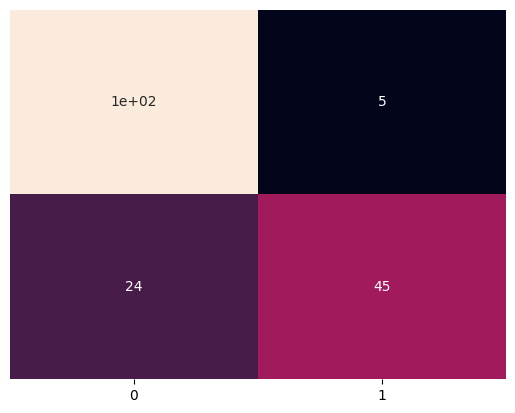

In [63]:
rf_clf_tuned = RandomForestClassifier(**best_params_rf,random_state=0)
rf_clf_tuned.fit(X_train, y_train)
acc , f1 , roc_auc=evaluate_model(rf_clf_tuned)
accuracy_dict['RF-Tuned']=acc
f1_scores['RF-Tuned']=f1
roc_auc_scores['RF-Tuned']=roc_auc

Will just try to tune the model again , this time keeping the hyperparameter choices close to what best parameters we got before

In [64]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params_grid = {
    'n_estimators': [500, 700, 900],
    'max_features': [ 'sqrt'],
    'max_depth': [2, 5 , 7],
    'min_samples_split': [3,4,5],
    'min_samples_leaf': [2, 4, 8],
    'bootstrap': [False]
}

rf_clf=RandomForestClassifier(random_state=0)
rf_cv=RandomizedSearchCV(
    rf_clf ,
    params_grid ,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=1,
)

rf_cv.fit(X_train , y_train)
best_params_rf=rf_cv.best_params_
print(f"Best parameters: {best_params_rf}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}


Accuracy Score Test: 83.80%
_______________________________________________
Accuracy Score Train: 83.57%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.813953   0.900000  0.837989    0.856977      0.847122
recall       0.954545   0.652174  0.837989    0.803360      0.837989
f1-score     0.878661   0.756303  0.837989    0.817482      0.831495
support    110.000000  69.000000  0.837989  179.000000    179.000000
_______________________________________________


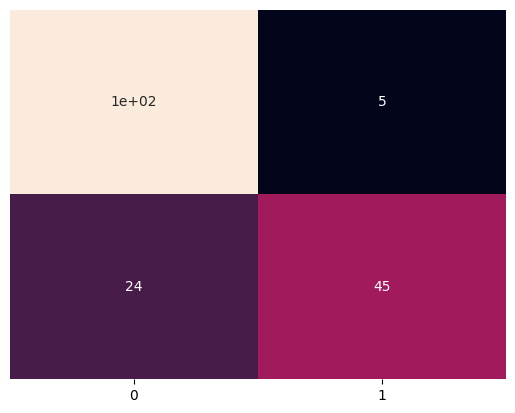

In [65]:
rf_clf_tuned = RandomForestClassifier(**best_params_rf,random_state=0)
rf_clf_tuned.fit(X_train, y_train)
acc , f1 , roc_auc=evaluate_model(rf_clf_tuned)
accuracy_dict['RF-Tuned']=acc
f1_scores['RF-Tuned']=f1
roc_auc_scores['RF-Tuned']=roc_auc

There is not much difference in test accuracy , but train accuracy improves a bit.

## Boosting Techniques

Now we will be using some of the boosting techniques to train our model. The main idea of boosting is that it creates multiple weak learners and combines them to form a strong learner.

Moreover it learns sequentially new learners learn from mistakes of previous ones and take them into account while learning



### a)XGBoost

Accuracy Score Test: 79.89%
_______________________________________________
Accuracy Score Train: 92.13%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.816514   0.771429  0.798883    0.793971      0.797875
recall       0.847619   0.729730  0.798883    0.788674      0.798883
f1-score     0.831776   0.750000  0.798883    0.790888      0.797969
support    105.000000  74.000000  0.798883  179.000000    179.000000
_______________________________________________


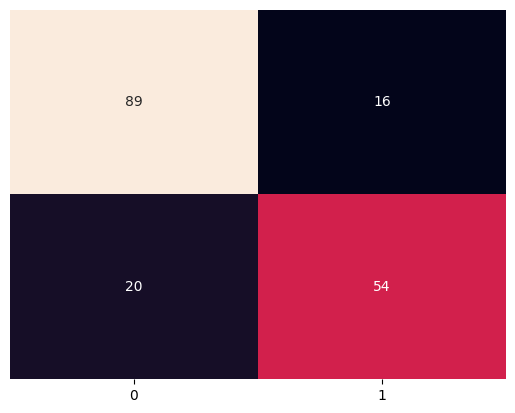

In [153]:
from xgboost import XGBClassifier
xgb_model=XGBClassifier(random_state=0 )
xgb_model.fit(X_train , y_train)
acc, f1 , roc_auc=evaluate_model(xgb_model)
accuracy_dict['xgb']=acc
f1_scores['xgb']=f1
roc_auc_scores['xgb']=roc_auc


Accuracy Score Test: 79.89%
_______________________________________________
Accuracy Score Train: 83.01%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.794872   0.806452  0.798883    0.800662      0.799659
recall       0.885714   0.675676  0.798883    0.780695      0.798883
f1-score     0.837838   0.735294  0.798883    0.786566      0.795445
support    105.000000  74.000000  0.798883  179.000000    179.000000
_______________________________________________


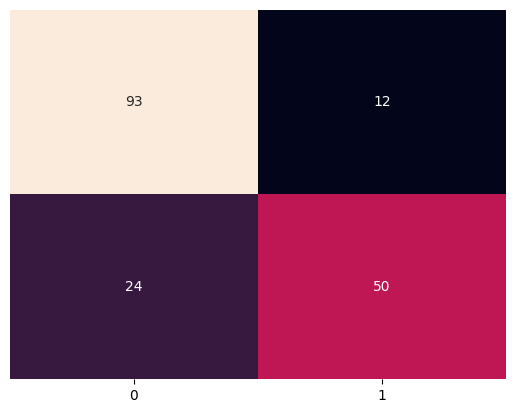

In [162]:
# Parameter tuning
xgb_model_tuned=XGBClassifier(n_estimators=1000, eta=0.5 ,random_state=0,reg_alpha=10 )
xgb_model_tuned.fit(X_train , y_train)
acc ,f1, roc_auc=evaluate_model(xgb_model_tuned)
accuracy_dict['xgb_tuned']=acc
f1_scores['xgb_tuned']=f1
roc_auc_scores['xgb_tuned']=roc_auc

# Added reg_alpha alias for alpha L1 regularization parameter , so that model generalizes well

# eta - learning rate , controls how much each model contributes to the overall prediction


In [68]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### b)LightGBM

Accuracy Score Test: 80.45%
_______________________________________________
Accuracy Score Train: 89.19%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.837838   0.750000  0.804469    0.793919      0.803979
recall       0.845455   0.739130  0.804469    0.792292      0.804469
f1-score     0.841629   0.744526  0.804469    0.793077      0.804198
support    110.000000  69.000000  0.804469  179.000000    179.000000
_______________________________________________


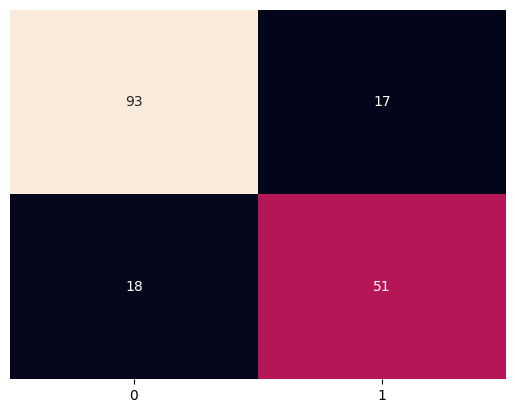

In [69]:
import lightgbm as lgb
lgb_clf=lgb.LGBMClassifier(random_state=0,verbose=-1)
lgb_clf.fit(X_train , y_train)
acc , f1 , roc_auc=evaluate_model(lgb_clf)
accuracy_dict['lgb']=acc
f1_scores['lgb']=f1
roc_auc_scores['lgb']=roc_auc

Accuracy Score Test: 81.01%
_______________________________________________
Accuracy Score Train: 84.13%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.798319   0.833333  0.810056    0.815826      0.812794
recall       0.904762   0.675676  0.810056    0.790219      0.810056
f1-score     0.848214   0.746269  0.810056    0.797241      0.806069
support    105.000000  74.000000  0.810056  179.000000    179.000000
_______________________________________________


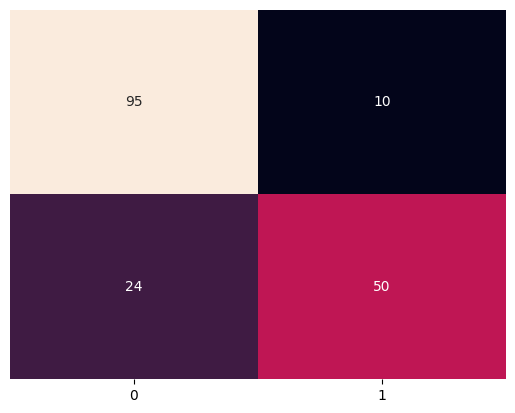

In [178]:
params={
    'learning_rate':0.05,
     'num_boost_round':1000,
     'lambda_l1':2.5,  #l1 regularization parameter , to control overfitting
}

lgb_clf_tuned=lgb.LGBMClassifier(**params,random_state=0 , verbose=-1)
lgb_clf_tuned.fit(X_train , y_train)

acc , f1 , roc_auc=evaluate_model(lgb_clf_tuned)
accuracy_dict['lgb_tuned']=acc
f1_scores['lgb_tuned']=f1
roc_auc_scores['lgb_tuned']=roc_auc

# 79 91

###c) Adaboost

Accuracy Score Test: 78.77%
_______________________________________________
Accuracy Score Train: 78.65%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.821429   0.731343  0.787709    0.776386      0.786703
recall       0.836364   0.710145  0.787709    0.773254      0.787709
f1-score     0.828829   0.720588  0.787709    0.774709      0.787105
support    110.000000  69.000000  0.787709  179.000000    179.000000
_______________________________________________


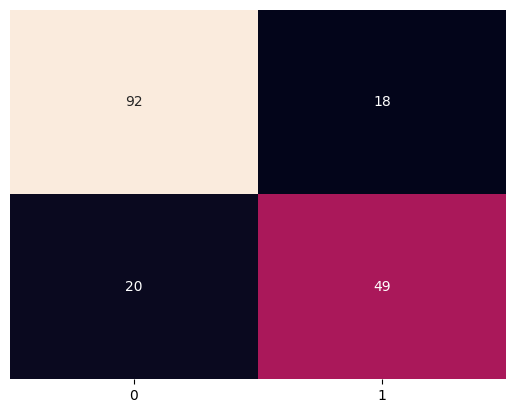

In [71]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=100 , learning_rate=0.01 ,random_state=0)
ada_clf=abc.fit(X_train  , y_train)
acc , f1 , roc=evaluate_model(ada_clf)
accuracy_dict['Adaboost']=acc
f1_scores['Adaboost']=f1
roc_auc_scores['Adaboost']=roc_auc

# Tried using SVC base estimator , but didnt turn out well

Accuracy Score Test: 81.01%
_______________________________________________
Accuracy Score Train: 92.84%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.825688   0.785714  0.810056    0.805701      0.809163
recall       0.857143   0.743243  0.810056    0.800193      0.810056
f1-score     0.841121   0.763889  0.810056    0.802505      0.809193
support    105.000000  74.000000  0.810056  179.000000    179.000000
_______________________________________________


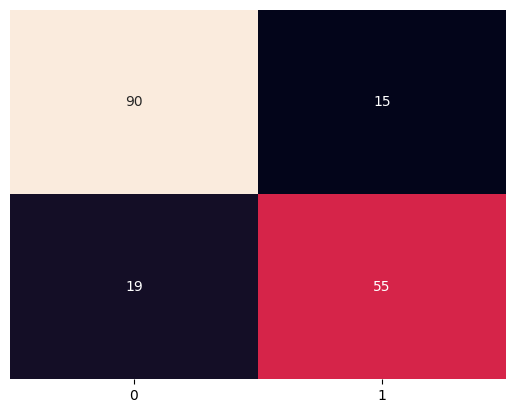

In [206]:
dt = DecisionTreeClassifier(max_depth=6 , random_state=0 )
abc_tuned =AdaBoostClassifier(n_estimators=800,learning_rate=0.05, base_estimator=dt, random_state=0)

ada_clf_tuned=abc_tuned.fit(X_train , y_train)
acc , f1 , roc_auc=evaluate_model(ada_clf_tuned)
accuracy_dict['Adaboost_tuned']=acc
f1_scores['Adaboost_tuned']=f1
roc_auc_scores['Adaboost_tuned']=roc_auc
# 81 92

## KNN

In [73]:
# Scaling values
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [74]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn=KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2 )
clf_knn.fit(X_train , y_train)

KNeighborsClassifier()

Accuracy Score Test: 83.80%
_______________________________________________
Accuracy Score Train: 83.85%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.858407   0.803030  0.837989    0.830719      0.837061
recall       0.881818   0.768116  0.837989    0.824967      0.837989
f1-score     0.869955   0.785185  0.837989    0.827570      0.837278
support    110.000000  69.000000  0.837989  179.000000    179.000000
_______________________________________________


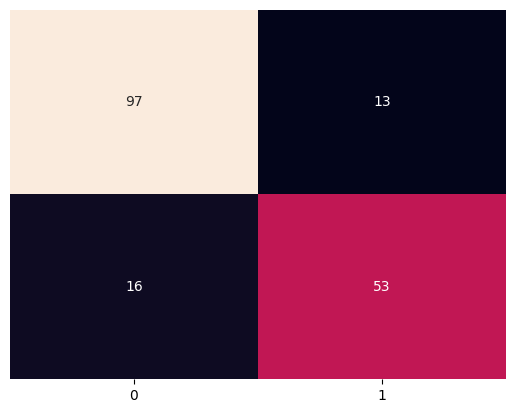

In [75]:
acc , f1 , roc_auc=evaluate_model(clf_knn)
accuracy_dict['knn']=acc
f1_scores['knn']=f1
roc_auc_scores['knn']=roc_auc

In [213]:
def evaluate_metric_diff_models(metric_dict):
  sorted_metric_dict=dict(sorted(metric_dict.items(), key=lambda item: item[1], reverse=True))
  keys = list(sorted_metric_dict.keys())
  values = list(sorted_metric_dict.values())
  df = pd.DataFrame({'Keys': keys, 'Values': values})

  # Create the bar plot
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Keys', y='Values', data=df , palette='mako' )
  plt.xlabel('Different Models')
  plt.ylabel('Values')
  plt.xticks(rotation=45)
  plt.title('Histogram from Highest to Lowest Values')
  plt.show()

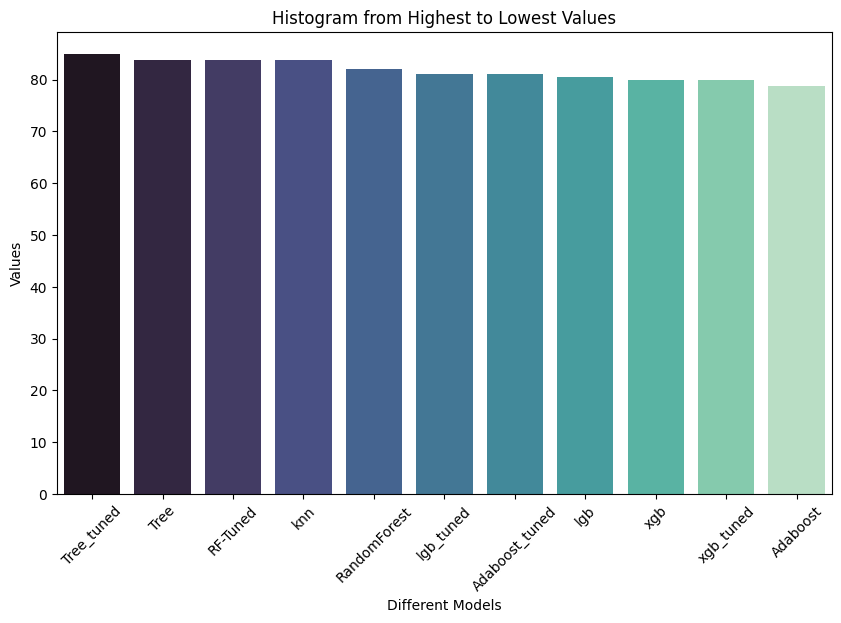

In [214]:
evaluate_metric_diff_models(accuracy_dict)

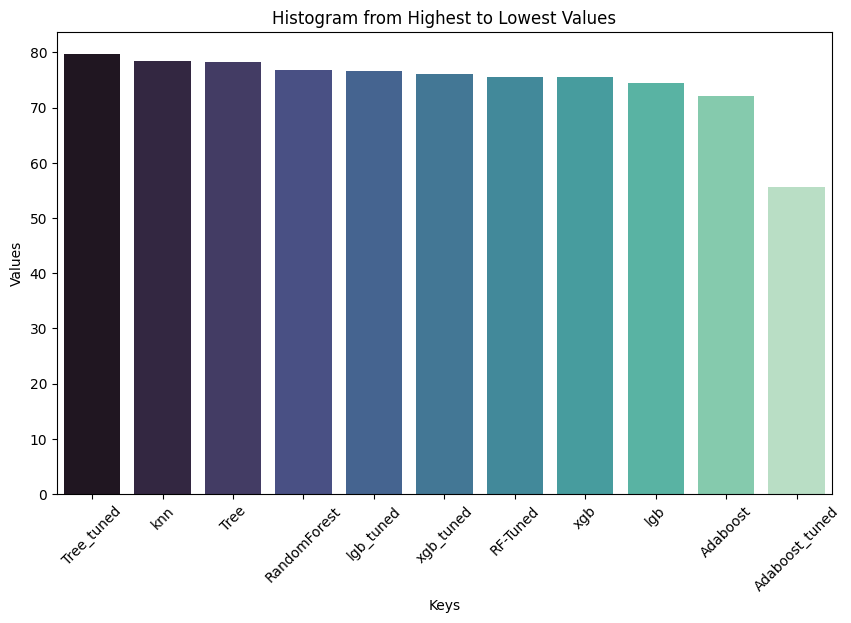

In [78]:
evaluate_metric_diff_models(f1_scores)


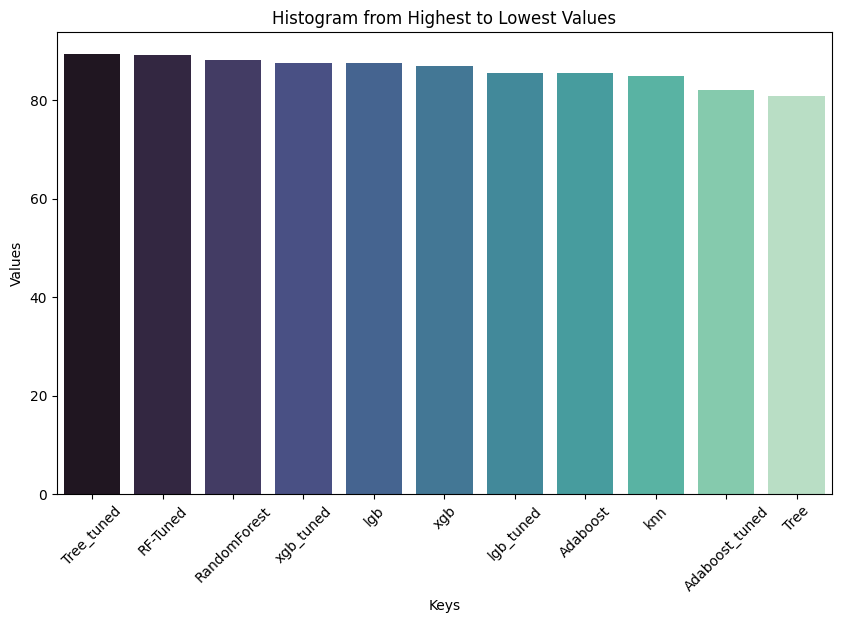

In [79]:
evaluate_metric_diff_models(roc_auc_scores)

From the above graphs its quite clear that Adaboost did not perform well on titanic dataset , while Decision Trees after Hyperparameter tuning performed really well.

They are good at both distinguishing positive and negative classes and correctly classifying the classes.

Knn has a high accuracy and high f1 score but low roc_auc_score

may be the model is particularly good at predicting the majority class but struggles with the minority class ,or issue with the probability estimates
(which the input required while calculating roc_auc but not while accuracy and f1 score)

## Applying Dimentionality Reduction Techniques

In [80]:
from sklearn.feature_selection import SelectKBest , f_classif , VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

In [81]:
X=df.drop('Survived' , axis='columns')
y=df['Survived']

In [82]:
# Removing constant features

selector=VarianceThreshold()
X_selected=selector.fit_transform(X)


In [83]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [84]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [85]:
X_train.shape

(712, 9)

In [86]:
# Performing feature selection
selector_kbest=SelectKBest(score_func=f_classif , k=7)
X_train_selected=selector_kbest.fit_transform(X_train_scaled , y_train)
X_test_selected=selector_kbest.transform(X_test_scaled)

In [87]:
# Perform the dimentionality reduction
pca=PCA(n_components=5)
X_train_pca=pca.fit_transform(X_train_selected)
X_test_pca=pca.transform(X_test_selected)

In [88]:
rf_clf_before=RandomForestClassifier(n_estimators=100 , random_state=42)
rf_clf_before.fit(X_train_scaled , y_train)

RandomForestClassifier(random_state=42)

In [89]:
y_pred_before=rf_clf_before.predict(X_test_scaled)
print("Accuracy before : {} ".format(accuracy_score(y_test,y_pred_before)  ))


Accuracy before : 0.7988826815642458 


In [90]:
rf_clf_after=RandomForestClassifier(n_estimators=100 , random_state=42)
rf_clf_after.fit(X_train_pca , y_train)

RandomForestClassifier(random_state=42)

In [91]:
y_pred_after = rf_clf_after.predict(X_test_pca)
accuracy_after = accuracy_score(y_test, y_pred_after)
print(f'Accuracy after dimensionality reduction: {accuracy_after}')

Accuracy after dimensionality reduction: 0.7932960893854749
